In [5]:
import keras
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from keras.wrappers.scikit_learn import KerasRegressor # this is for making a model like every other in scikit
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from time import time
import matplotlib.pyplot as plt

# import tensorflow as tf
# config = tf.ConfigProto(device_count={"CPU": 15})

### Load data

In [3]:
Interactions = []

with open("interactions_kinases_IC50_train.tab", 'r') as file:
    header_line = next(file)
    for line in file:
        tokens = line.split()
        # 'Target-ID', 'Compound-ID', 'Std-value'  
        Interactions.append( [tokens[0], tokens[1], tokens[2] ])

# we use a dataframe to quickly sort targets wrt #compounds:
DF = pd.DataFrame( Interactions, columns =['Target-ID', 'Compound-ID','Std-value']) 
temp = DF.groupby(['Target-ID']).agg('count').sort_values(by='Compound-ID') # count the number of molecules
Targets = list(temp.index)
Compounds = np.unique(DF['Compound-ID'])
del temp, DF

nT=len(Targets); nC=len(Compounds)

print("There are {0} targets and {1} compounds currently loaded with {2} interactions.".format(nT,nC,len(Interactions)))
print("A DTI matrix would be {0:.4}% dense!".format(100.0*len(Interactions)/nT/nC ))

# load fingerprints and prepare as feature vectors
Fingerprints={} # this contains one list per fingerprint - not efficient...
with open('Compound_Fingerprints.tab', 'r') as f:
    header = f.readline()
    for line in f:
        # each line is Comp-ID, SMILES, FP
        tokens = line.split()
        # we keep only those compounds which have FPs
        if tokens[2] != 'NOFP':
            fp = [int(c) for c in tokens[2] ]
            Fingerprints[ tokens[0] ] = fp
print("%d fingerprints were loaded!" % len(Fingerprints))

# split to train/test data
random_seed = 2019
np.random.seed(random_seed)

indices = list(range(len(Interactions)))
split = int(np.floor( 0.2*( len(indices)) ))
# split the active interactions in train-test sets
np.random.shuffle( indices ) # this happens in-place

Interactions_train = [ Interactions[x] for x in indices[split:] ] # the last 80%
Interactions_valid = [ Interactions[x] for x in indices[:split] ] # the first 20%

There are 110 targets and 23167 compounds currently loaded with 56392 interactions.
A DTI matrix would be 2.213% dense!
155083 fingerprints were loaded!


### Train with 80% data and validate

In [66]:
myNN_all = dict()
Scores_myNN_train=[]
count=0

def mymodel(init=250):
    model = Sequential()
    model.add(Dense(units=50, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_dim=2048))
    model.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    
    myinit = keras.initializers.Constant(value=init)
    model.add(Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.01)))
    
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=0.01))

    return model

for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        # we need to ensure there is enough data for CV
#         cvr = GridSearchCV(RandomForestRegressor(random_state=2019), param_grid, cv=5, n_jobs=5, iid=True)
        # here comes the long step
#         cvr.fit(X_train, Y_train)
        # select best parametrisation and train to the complete train-set

#         mymod = mymodel(np.median(Y_train))
        X_train = np.array( X_train )

        myNN = KerasRegressor(build_fn=mymodel, epochs=300, batch_size=25, verbose=0)

        myNN.fit(X_train,Y_train)
        Y_NN = myNN.predict(X_train)
        Scores_myNN_train.append( r2_score(Y_train, Y_NN) )
        print(Scores_myNN_train[-1])
        myNN_all[target] = myNN # save model for validation
    else:
        print("Not enough data for %s" % target)
    if count%25==0:print("More than %d targets are processed" % count)
    count+=1
    
print("Mean score for myNN during training = %f" % np.mean(Scores_myNN_train) )

0.9967914249865316
More than 0 targets are processed
0.9999171417889567
0.9379698652434669
0.8212600100314973
0.9880878881291362
0.9995748820158233
0.9998695220009597
0.9999036875233831
0.9999313678337538
0.9999303431856824
0.9991720861374638
0.9915027808920098
0.9891937307945423
0.999054689351034
0.9995742190046861
0.998400726683268
0.9993883355333691
0.9648454712007088
0.9994155131932607
0.9965504184208577
0.9661975441473158
0.9924153055630269
0.9995898337559986
0.9942130992228116
0.991083427080316
0.9999438165502931
More than 25 targets are processed
0.9998533651213568
0.9967593883778714
0.9998569575138958
0.9937451472351065
0.9998356350480749
0.9926562802930443
0.9879159621865828
-0.005885657053366966
0.998840929548769
0.996791570584939
0.9904102381838518
0.9973087778503563
0.9999001294872129
0.9998936666822054
0.999364719621954
0.9960973921042635
0.9994589562007274
0.9987816355677465
0.9984831276239071
0.9996145420334273
0.9991148543082913
0.9999907668234989
0.9986089534083092
0.9

In [67]:
Pred_myNN = []
True_vals = []
Pred_pertarget = dict() # contains lists with tuples: (true, pred_RF, pred_NN)

for point in Interactions_valid:
    True_vals.append( float(point[2]) )
    x_test = np.array( Fingerprints[point[1]] )

    model = myNN_all[point[0]]
    Pred_myNN.append( model.predict( x_test.reshape(1,-1) ) )

    if point[0] in Pred_pertarget:
        Pred_pertarget[point[0]].append( (True_vals[-1], Pred_myNN[-1])  )
    else:
        # first time for this protein
        Pred_pertarget[point[0]] = [ (True_vals[-1], Pred_myNN[-1]) ]
            
print("Performance for myNN = %f" % r2_score(True_vals, Pred_myNN))

Performance for myNN = 0.314916


### Per target validation

In [76]:
Scores_myNN_valid_pertarget  = []

for target in Pred_pertarget:
    true=[]
    pred_myNN=[];
    # aggregate predictions
    for things in Pred_pertarget[target]:
        true.append( things[0] )
        pred_myNN.append( things[1] )
    # calculate performance
    Scores_myNN_valid_pertarget.append(r2_score(true, pred_myNN) )

    print("R2 score for {0} with myNN = {1}".format(target, Scores_myNN_valid_pertarget[-1]))
    
print("Mean per target R2-score for NN = %f " % np.mean(Scores_myNN_valid_pertarget))

R2 score for CHEMBL260 with myNN = 0.23619318921548382
R2 score for CHEMBL4722 with myNN = 0.2695444426742143
R2 score for CHEMBL2695 with myNN = 0.2044505894300258
R2 score for CHEMBL3038477 with myNN = 0.6110239631093612
R2 score for CHEMBL2996 with myNN = -0.06563737755911325
R2 score for CHEMBL2148 with myNN = 0.5891616979234737
R2 score for CHEMBL2147 with myNN = 0.4964523680016656
R2 score for CHEMBL5147 with myNN = 0.3008063522828497
R2 score for CHEMBL308 with myNN = 0.43721033787367636
R2 score for CHEMBL3234 with myNN = -0.13468493124100966
R2 score for CHEMBL4523 with myNN = 0.3108804747292174
R2 score for CHEMBL2358 with myNN = 0.15000269101488883
R2 score for CHEMBL1936 with myNN = 0.0597092692264265
R2 score for CHEMBL3629 with myNN = 0.4411510878428213
R2 score for CHEMBL279 with myNN = 0.10241302304312938
R2 score for CHEMBL1824 with myNN = 0.3167112329683427
R2 score for CHEMBL203 with myNN = 0.2551736312910766
R2 score for CHEMBL1862 with myNN = 0.1508973632642866
R2 

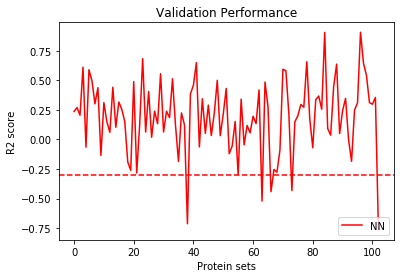

In [75]:
plt.figure()
plt.plot([x for x in Scores_myNN_valid_pertarget if x> -1],'r', label='NN')
plt.axhline(np.mean(Scores_myNN_valid_pertarget),color='r', linestyle='--')

plt.legend(loc=4)
plt.xlabel('Protein sets')
plt.ylabel('R2 score')
plt.title("Validation Performance")
plt.show()

In [ ]:
# Y_NNR = myNNR.predict(X_train)
for i in range(50):
    print(True_vals[i],'\t', Pred_myNN[i])
print(     MSE( True_vals, Pred_myNN ))
print(r2_score( True_vals, Pred_myNN ))
print(     MAE( True_vals, Pred_myNN ))

## Predict scaled/standardized values

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# scaler = StandardScaler()
scaler = MinMaxScaler()

myNN_all = dict()
Scores_myNN_train=[]
count=0

def mymodel(init=250):
    model = Sequential()
    model.add(Dense(units=100, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_dim=2048))
    model.add(Dense(units=10, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
    
    myinit = keras.initializers.Constant(value=init)
    model.add(Dense(1, kernel_initializer=myinit, activity_regularizer=regularizers.l1(0.01)))
    
    model.compile(loss='mean_squared_error', optimizer=keras.optimizers.adam(lr=0.01))

    return model

for target in Targets:
    # define the train set
    X_train=[]; Y_train=[]
    for point in Interactions_train:
        if point[0]==target:
            X_train.append( Fingerprints[point[1]] )
            Y_train.append( float(point[2]) )
    if len(Y_train)>40:
        X_train = np.array( X_train )
        scaler.fit(np.array(Y_train).reshape(-1, 1))
        Y_scaled = scaler.transform( np.array(Y_train).reshape(-1, 1) ) #, copy=True)

        myNN = KerasRegressor(build_fn=mymodel, epochs=500, batch_size=25, verbose=0)
        myNN.fit(X_train,Y_scaled)
        Y_NN = myNN.predict(X_train)
        Y_pred = scaler.inverse_transform(Y_NN.reshape(-1, 1))
        
        Scores_myNN_train.append( r2_score(Y_train, Y_pred) )
        print(Scores_myNN_train[-1])
        myNN_all[target] = myNN # save model for validation
    else:
        print("Not enough data for %s" % target)
    if count%25==0:print("More than %d targets are processed" % count)
    count+=1
    
print("Mean score for myNN during training = %f" % np.mean(Scores_myNN_train) )

-0.22537449419293298
More than 0 targets are processed
-0.19357432314665668
-0.1888431083090083
-0.28090843482724837
-0.12582547895823626
-0.05917331991184516
-0.17518632039349913


In [97]:
myNN.fit(X_train,Y_scaled)
Y_NN = myNN.predict(X_train)
Y_pred = scaler.inverse_transform(Y_NN.reshape(-1, 1))

Scores_myNN_train.append( r2_score(Y_train, Y_pred) )